# Loading Dataset 

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils import shuffle, class_weight
from sklearn.feature_extraction import FeatureHasher
import os

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
file_path = r"C:\Users\shravya\PycharmProjects\minor\DDOS Dataset.csv"
print("Loading dataset...")
df = pd.read_csv(file_path)
print(f"Original dataset shape: {df.shape}")

Loading dataset...
Original dataset shape: (15462150, 26)


In [11]:
df.head()

,timestamp,flow_id,ip_src,tp_src,ip_dst,tp_dst,ip_proto,flow_duration_sec,flow_duration_nsec,idle_timeout,...,byte_count_per_nsecond,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Cnt,ECE_Flag_Cnt,label
0,1.589933e+09,10.0.0.1505010.0.0.3542466,10.0.0.1,5050,10.0.0.3,54246,6,4,480000000.0,20,...,6.981700e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.589933e+09,10.0.0.35424610.0.0.150506,10.0.0.3,54246,10.0.0.1,5050,6,4,486000000.0,20,...,2.435180e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.589933e+09,10.0.0.35424610.0.0.550501,10.0.0.3,54246,10.0.0.5,5050,1,4,484000000.0,20,...,6.074380e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.589933e+09,10.0.0.55424610.0.0.350501,10.0.0.5,54246,10.0.0.3,5050,1,4,415000000.0,20,...,7.084337e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.589933e+09,10.0.0.3010.0.0.501,10.0.0.3,0,10.0.0.5,0,1,4,423000000.0,20,...,6.950355e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
# unique identifiers
df = df.drop(columns=['flow_id', 'ip_src', 'ip_dst'], errors='ignore')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Drop constant columns
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
df.drop(columns=constant_cols, inplace=True)

# Feature Hashing and Scaling 

In [16]:

# Feature hashing 
high_card_cols = ['flow_id', 'ip_src']
existing_high_card_cols = [col for col in high_card_cols if col in df.columns]
if existing_high_card_cols:
    hasher = FeatureHasher(n_features=5, input_type='string')
    hashed_features = hasher.transform(df[existing_high_card_cols].astype(str).to_dict('records'))
    df_hashed = pd.DataFrame(hashed_features.toarray(), columns=[f'hash_{i}' for i in range(5)])
    df.drop(columns=existing_high_card_cols, inplace=True)
    df = pd.concat([df, df_hashed], axis=1)

# Scale numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('label')
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [18]:
df.head()

,timestamp,tp_src,tp_dst,ip_proto,flow_duration_sec,flow_duration_nsec,packet_count,byte_count,packet_count_per_second,packet_count_per_nsecond,byte_count_per_second,byte_count_per_nsecond,label
0,0.000000e+00,0.077058,0.889308,0.3125,0.04,0.480480,7.448038e-03,7.970546e-05,0.026278,1.542260e-04,1.093869e-04,1.783538e-07,0
1,0.000000e+00,0.827741,0.082790,0.3125,0.04,0.486486,3.070981e-02,2.814835e-01,0.108348,6.280553e-04,3.863048e-01,6.220886e-04,0
2,0.000000e+00,0.827741,0.082790,0.0000,0.04,0.484484,4.400527e-07,6.992509e-09,0.000002,9.036835e-09,9.596439e-09,1.551755e-11,0
3,0.000000e+00,0.827741,0.082790,0.0000,0.04,0.415415,4.400527e-07,6.992509e-09,0.000002,1.053935e-08,9.596439e-09,1.809758e-11,0
4,2.411070e-09,0.000000,0.000000,0.0000,0.04,0.423423,4.400527e-07,6.992509e-09,0.000002,1.034002e-08,9.596439e-09,1.775531e-11,0


# Encoding 

In [21]:

# Encode target if categorical
if df['label'].dtype == 'object':
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])



# Selecting features Based on correlation 

Selected features based on correlation with the target label (|correlation| ≥ 0.1):
1. timestamp
2. tp_dst
3. ip_proto
4. flow_duration_sec
5. packet_count
6. byte_count
7. packet_count_per_second
8. byte_count_per_second


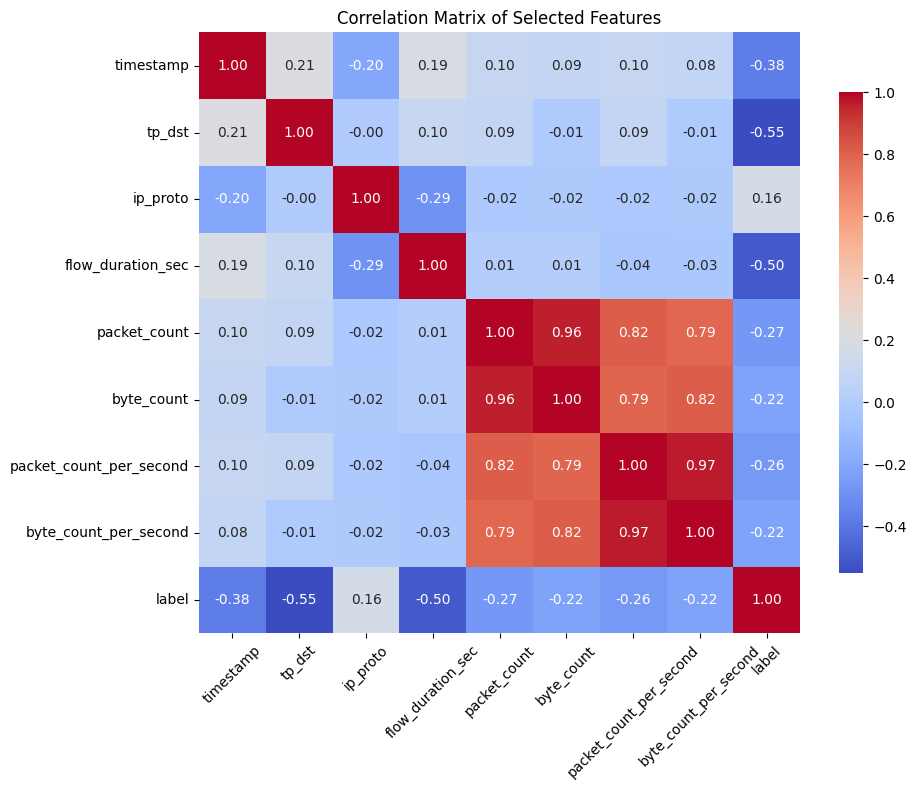

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Correlation-based feature selection ---
correlation_with_target = df.corr()['label'].drop('label')
selected_features = correlation_with_target[abs(correlation_with_target) >= 0.1].index.tolist()
df = df[selected_features + ['label']]

# Display the selected features
print("Selected features based on correlation with the target label (|correlation| ≥ 0.1):")
for i, feature in enumerate(selected_features, start=1):
    print(f"{i}. {feature}")

# --- Plot correlation matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Selected Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Dataset size after correlation 

In [121]:
df.shape

(2667523, 9)

# Stratified split and Shuffling to remove bias

In [33]:

# Shuffle and split dataset
df = shuffle(df, random_state=42)
X = df.drop(columns=['label']).values
y = df['label'].values

# Stratified train-test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

# Data Reshaping for LSTM and Handling Class Imbalance

In [35]:
# Reshape data for LSTM (1 timestep)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Class weights for imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(1.4707587507339948), 1: np.float64(0.757530513952075)}


# Importing TensorFlow Keras Components

In [39]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout,
    BatchNormalization, Flatten, Concatenate
)
from tensorflow.keras import regularizers, constraints
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hybrid LSTM-ANN Model Architecture for Binary Classification

In [42]:

inp = Input(shape=(1, X_train.shape[1]))

# LSTM branch: very small + heavy reg
lstm = LSTM(
    16,
    return_sequences=False,
    kernel_regularizer=regularizers.l2(0.02),
    kernel_constraint=constraints.max_norm(3)
)(inp)
lstm = Dropout(0.5)(lstm)
lstm = Dense(
    8,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.02),
    kernel_constraint=constraints.max_norm(3)
)(lstm)

# ANN branch: small + heavy reg
flat = Flatten()(inp)
ann = Dense(
    32,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.02),
    kernel_constraint=constraints.max_norm(3)
)(flat)
ann = BatchNormalization()(ann)
ann = Dropout(0.5)(ann)
ann = Dense(
    16,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.02),
    kernel_constraint=constraints.max_norm(3)
)(ann)

# Merge branches
merged = Concatenate()([lstm, ann])
merged = Dense(
    8,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.02),
    kernel_constraint=constraints.max_norm(3)
)(merged)
merged = Dropout(0.4)(merged)

out = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=inp, outputs=out)

# --- 2) Compile with a lower LR ---
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)


# Callbacks to control Overfitting and Learning Rate Adjustment

In [45]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1
)


# Model Training with Class Weights and Callbacks

In [48]:
history = model.fit(
    X_train_lstm, y_train,
    epochs=5,
    batch_size=256,
    validation_data=(X_test_lstm, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/5
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9155 - loss: 0.5120 - precision: 0.9190 - recall: 0.9543 - val_accuracy: 0.9687 - val_loss: 0.1671 - val_precision: 0.9547 - val_recall: 0.9999 - learning_rate: 5.0000e-04
Epoch 2/5
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9579 - loss: 0.2125 - precision: 0.9426 - recall: 0.9969 - val_accuracy: 0.9686 - val_loss: 0.1535 - val_precision: 0.9546 - val_recall: 0.9999 - learning_rate: 5.0000e-04
Epoch 3/5
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9593 - loss: 0.1979 - precision: 0.9444 - recall: 0.9969 - val_accuracy: 0.9731 - val_loss: 0.1398 - val_precision: 0.9609 - val_recall: 0.9999 - learning_rate: 5.0000e-04
Epoch 4/5
8309/8337 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9620 - loss: 0.1873 - precision: 0.9473 - recall: 0.9980
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
8337/8337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9621 - loss: 0.1873 - 

# Evaluating Model on Training Set 

In [51]:

# --- Evaluate on Training Set ---
train_loss, train_accuracy, train_precision, train_recall = model.evaluate(X_train_lstm, y_train, verbose=0)
y_train_pred = (model.predict(X_train_lstm, verbose=0) > 0.5).astype("int32")
train_f1 = f1_score(y_train, y_train_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("\n TRAIN SET EVALUATION")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print("\nTrain Confusion Matrix:")
print(train_conf_matrix)


 TRAIN SET EVALUATION
Train Loss: 0.1257
Train Accuracy: 0.9756
Train Precision: 0.9644
Train Recall: 0.9999
Train F1-Score: 0.9818

Train Confusion Matrix:
[[ 673440   52042]
 [    105 1408431]]


# Evaluating Model Performance On Test Set

In [55]:

# --- Evaluate on Test Set ---
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_lstm, y_test, verbose=0)
y_test_pred = (model.predict(X_test_lstm, verbose=0) > 0.5).astype("int32")
test_f1 = f1_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nTEST SET EVALUATION")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print("\nTest Confusion Matrix:")
print(test_conf_matrix)



TEST SET EVALUATION
Test Loss: 0.1264
Test Accuracy: 0.9752
Test Precision: 0.9638
Test Recall: 0.9999
Test F1-Score: 0.9816

Test Confusion Matrix:
[[168156  13215]
 [    22 352112]]


# FGSM-Based Adversarial Samples Generation 

### Combining test and train set for fgsm input 

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score

# --- Combine Train and Test Data ---
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Defining FGSM Attack Function

In [65]:
# --- FGSM Attack Function ---
def fgsm_attack(model, X, y, epsilon=0.1, batch_size=1024):
    X_adv = np.zeros_like(X)
    for i in range(0, len(X), batch_size):
        batch_end = min(i + batch_size, len(X))
        X_batch = tf.convert_to_tensor(X[i:batch_end], dtype=tf.float32)
        y_batch = y[i:batch_end]
        y_batch = tf.expand_dims(y_batch, axis=-1)

        # Reshape for LSTM
        X_batch_reshaped = tf.reshape(X_batch, (-1, 1, X_batch.shape[1]))

        with tf.GradientTape() as tape:
            tape.watch(X_batch_reshaped)
            predictions = model(X_batch_reshaped, training=False)
            loss = tf.keras.losses.binary_crossentropy(y_batch, predictions)
            loss = tf.reduce_mean(loss)

        gradient = tape.gradient(loss, X_batch_reshaped)
        signed_grad = tf.sign(gradient)
        X_adv_batch = X_batch_reshaped + epsilon * signed_grad
        X_adv_batch = tf.clip_by_value(X_adv_batch, 0, 1)

        X_adv[i:batch_end] = X_adv_batch.numpy().reshape(X_adv_batch.shape[0], -1)
        print(f"Processed batch {i // batch_size + 1}/{(len(X) // batch_size) + 1}")
    return X_adv


# Generating Adversarial Samples and Saving

In [67]:

print("\nGenerating FGSM adversarial examples for the entire combined dataset...")
X_combined_adv = fgsm_attack(model, X_combined, y_combined, epsilon=0.1, batch_size=1024)
print(f"Shape of X_combined_adv: {X_combined_adv.shape}")

# --- Save to CSV ---
pd.DataFrame(X_combined_adv).to_csv("X_combined_adv.csv", index=False)
print("Adversarial samples saved to 'X_combined_adv.csv'.")


Generating FGSM adversarial examples for the entire combined dataset...
Processed batch 1/2606
Processed batch 2/2606
Processed batch 3/2606
Processed batch 4/2606
Processed batch 5/2606
Processed batch 6/2606
Processed batch 7/2606
Processed batch 8/2606
Processed batch 9/2606
Processed batch 10/2606
Processed batch 11/2606
Processed batch 12/2606
Processed batch 13/2606
Processed batch 14/2606
Processed batch 15/2606
Processed batch 16/2606
Processed batch 17/2606
Processed batch 18/2606
Processed batch 19/2606
Processed batch 20/2606
Processed batch 21/2606
Processed batch 22/2606
Processed batch 23/2606
Processed batch 24/2606
Processed batch 25/2606
Processed batch 26/2606
Processed batch 27/2606
Processed batch 28/2606
Processed batch 29/2606
Processed batch 30/2606
Processed batch 31/2606
Processed batch 32/2606
Processed batch 33/2606
Processed batch 34/2606
Processed batch 35/2606
Processed batch 36/2606
Processed batch 37/2606
Processed batch 38/2606
Processed batch 39/2606


# Reshaping samples for Hybrid ANN + LSTM model

In [71]:
X_combined_adv_lstm = X_combined_adv.reshape((X_combined_adv.shape[0], 1, X_combined_adv.shape[1]))

# Evaluating Hybrid Model on Adversarial Samples 

In [74]:


print("\n Evaluating Hybrid ANN + LSTM Model on Adversarial Samples...")
adv_loss, adv_accuracy, adv_precision, adv_recall = model.evaluate(X_combined_adv_lstm, y_combined, verbose=0)
y_adv_pred = (model.predict(X_combined_adv_lstm, verbose=0) > 0.5).astype("int32")
adv_f1 = f1_score(y_combined, y_adv_pred)
adv_cm = confusion_matrix(y_combined, y_adv_pred)

print("\nEVALUATION ON ADVERSARIAL SAMPLES")
print(f"Adversarial Loss       : {adv_loss:.4f}")
print(f"Adversarial Accuracy   : {adv_accuracy:.4f}")
print(f"Adversarial Precision  : {adv_precision:.4f}")
print(f"Adversarial Recall     : {adv_recall:.4f}")
print(f"Adversarial F1-Score   : {adv_f1:.4f}")
print("Adversarial Confusion Matrix:")
print(adv_cm)



 Evaluating Hybrid ANN + LSTM Model on Adversarial Samples...

EVALUATION ON ADVERSARIAL SAMPLES
Adversarial Loss       : 12.6315
Adversarial Accuracy   : 0.2646
Adversarial Precision  : 0.0000
Adversarial Recall     : 0.0000
Adversarial F1-Score   : 0.0000
Adversarial Confusion Matrix:
[[ 705932  200921]
 [1760670       0]]


#  Combining original and adversarial data

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf


X_total = np.concatenate([X_combined, X_combined_adv], axis=0)
y_total = np.concatenate([y_combined, y_combined], axis=0)  # Same labels for adversarial samples

# split the data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_total, y_total, test_size=0.2, stratify=y_total, random_state=42
)

#  Reshape for LSTM input
X_train_final = X_train_final.reshape((X_train_final.shape[0], 1, X_train_final.shape[1]))
X_test_final = X_test_final.reshape((X_test_final.shape[0], 1, X_test_final.shape[1]))

# Testing Model on Combined Dataset

In [79]:

print("\nEvaluating model on combined dataset (original + adversarial)...")
loss, accuracy, precision, recall = model.evaluate(X_test_final, y_test_final, verbose=0)

# Calculate F1 Score
f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

# Display metrics
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
y_pred = (model.predict(X_test_final) > 0.5).astype(int)
cm = confusion_matrix(y_test_final, y_pred)
print("\nConfusion Matrix:")
print(cm)



Evaluating model on combined dataset (original + adversarial)...
Loss: 6.3757
Accuracy: 0.6203
Precision: 0.8689
Recall: 0.5003
F1 Score: 0.6349
33345/33345 ━━━━━━━━━━━━━━━━━━━━ 23s 681us/step

Confusion Matrix:
[[309571  53170]
 [351952 352317]]


# Retraining Hybrid Model To Make it more Robust

In [84]:


model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("\n Training Hybrid ANN + LSTM on Clean + Adversarial Samples...")
history = model.fit(X_train_final, y_train_final, epochs=10, batch_size=512,
                    validation_split=0.1, shuffle=True)




 Training Hybrid ANN + LSTM on Clean + Adversarial Samples...
Epoch 1/10
7503/7503 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9614 - loss: 0.1641 - precision: 0.9505 - recall: 0.9933 - val_accuracy: 0.9849 - val_loss: 0.0795 - val_precision: 0.9777 - val_recall: 1.0000
Epoch 2/10
7503/7503 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9729 - loss: 0.1146 - precision: 0.9620 - recall: 0.9984 - val_accuracy: 0.9347 - val_loss: 0.1737 - val_precision: 0.9833 - val_recall: 0.9169
Epoch 3/10
7503/7503 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9732 - loss: 0.1103 - precision: 0.9624 - recall: 0.9984 - val_accuracy: 0.9857 - val_loss: 0.0714 - val_precision: 0.9789 - val_recall: 1.0000
Epoch 4/10
7503/7503 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9735 - loss: 0.1075 - precision: 0.9628 - recall: 0.9984 - val_accuracy: 0.9859 - val_loss: 0.0698 - val_precision: 0.9792 - val_recall: 1.0000
Epoch 5/10
7503/7503 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9736 - loss: 0.1

# Evaluating on Test set and Performance results

In [88]:

print("\n Evaluating on Test Set (Clean + Adversarial)...")
loss, accuracy, precision, recall = model.evaluate(X_test_final, y_test_final, verbose=0)
y_pred_final = (model.predict(X_test_final, verbose=0) > 0.5).astype("int32")
f1 = f1_score(y_test_final, y_pred_final)
conf_matrix = confusion_matrix(y_test_final, y_pred_final)


print("\n FINAL EVALUATION ON COMBINED DATA")
print(f"Loss           : {loss:.4f}")
print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-Score       : {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)



 Evaluating on Test Set (Clean + Adversarial)...

 FINAL EVALUATION ON COMBINED DATA
Loss           : 0.0729
Accuracy       : 0.9830
Precision      : 0.9749
Recall         : 1.0000
F1-Score       : 0.9873

Confusion Matrix:
[[344601  18140]
 [     4 704265]]


# Visualising Results 

## Performance Measures of Hybrid Model On original,Adversarial Samples and combined datset 

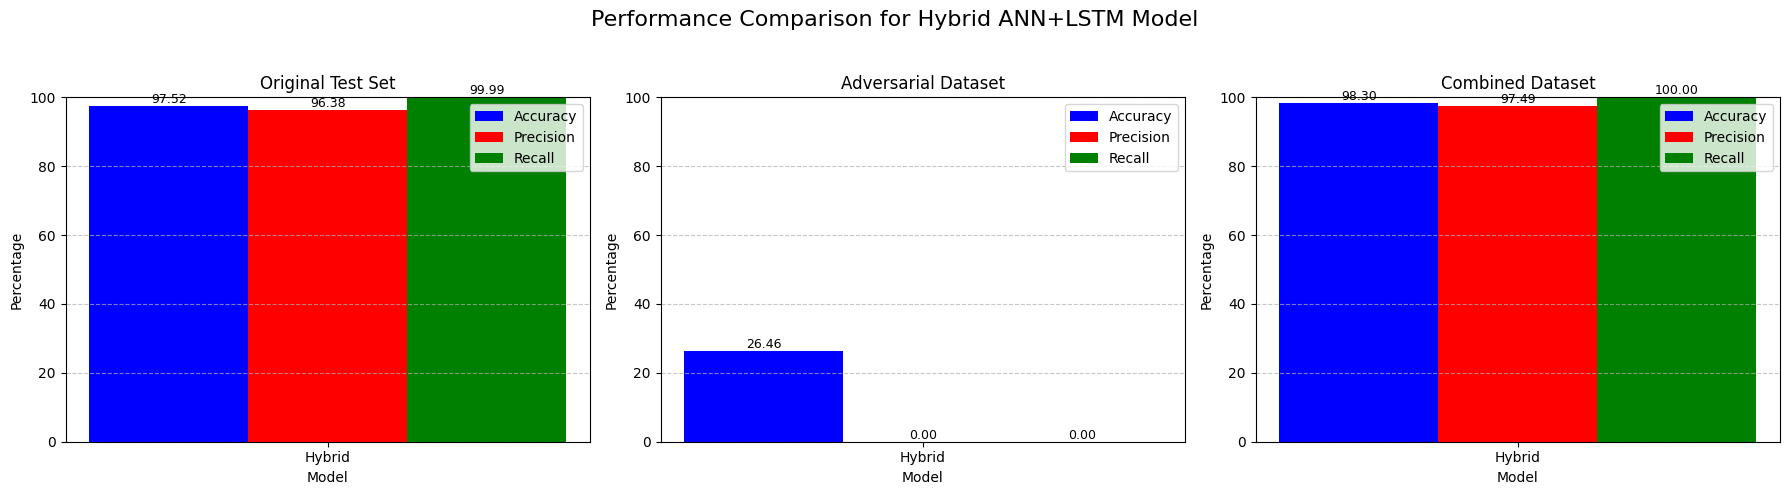

In [101]:
import matplotlib.pyplot as plt

# Figure 1: Bar Plots
plt.figure(figsize=(18, 5))
plt.suptitle('Performance Comparison for Hybrid ANN+LSTM Model', fontsize=16)

# Original Test Set
accuracy_orig = accuracy_score(y_test, y_test_pred) * 100
precision_orig = precision_score(y_test, y_test_pred) * 100
recall_orig = recall_score(y_test, y_test_pred) * 100

x = np.arange(1)
width = 0.2
plt.subplot(1, 3, 1)
bars1 = plt.bar(x - width, [accuracy_orig], width, label='Accuracy', color='blue')
bars2 = plt.bar(x, [precision_orig], width, label='Precision', color='red')
bars3 = plt.bar(x + width, [recall_orig], width, label='Recall', color='green')
plt.xlabel("Model")
plt.ylabel("Percentage")
plt.title("Original Test Set")
plt.xticks(x)
plt.xticks(x, ["Hybrid"])
plt.ylim(0, 100)
for bars, values in [(bars1, [accuracy_orig]), (bars2, [precision_orig]), (bars3, [recall_orig])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adversarial Dataset
accuracy_adv = accuracy_score(y_combined, y_adv_pred) * 100
precision_adv = precision_score(y_combined,y_adv_pred) * 100
recall_adv = recall_score(y_combined, y_adv_pred) * 100

plt.subplot(1, 3, 2)
bars1 = plt.bar(x - width, [accuracy_adv], width, label='Accuracy', color='blue')
bars2 = plt.bar(x, [precision_adv], width, label='Precision', color='red')
bars3 = plt.bar(x + width, [recall_adv], width, label='Recall', color='green')
plt.xlabel("Model")
plt.ylabel("Percentage")
plt.title("Adversarial Dataset")
plt.xticks(x)
plt.xticks(x, ["Hybrid"])
plt.ylim(0, 100)
for bars, values in [(bars1, [accuracy_adv]), (bars2, [precision_adv]), (bars3, [recall_adv])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Combined Dataset
accuracy_combined = accuracy_score(y_test_final, y_pred_final) * 100
precision_combined = precision_score(y_test_final, y_pred_final) * 100
recall_combined = recall_score(y_test_final, y_pred_final) * 100

plt.subplot(1, 3, 3)
bars1 = plt.bar(x - width, [accuracy_combined], width, label='Accuracy', color='blue')
bars2 = plt.bar(x, [precision_combined], width, label='Precision', color='red')
bars3 = plt.bar(x + width, [recall_combined], width, label='Recall', color='green')
plt.xlabel("Model")
plt.ylabel("Percentage")
plt.title("Combined Dataset")
plt.xticks(x)
plt.xticks(x, ["Hybrid"])
plt.ylim(0, 100)
for bars, values in [(bars1, [accuracy_combined]), (bars2, [precision_combined]), (bars3, [recall_combined])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Figure 3: ROC Curves


## Confusion Matrices 

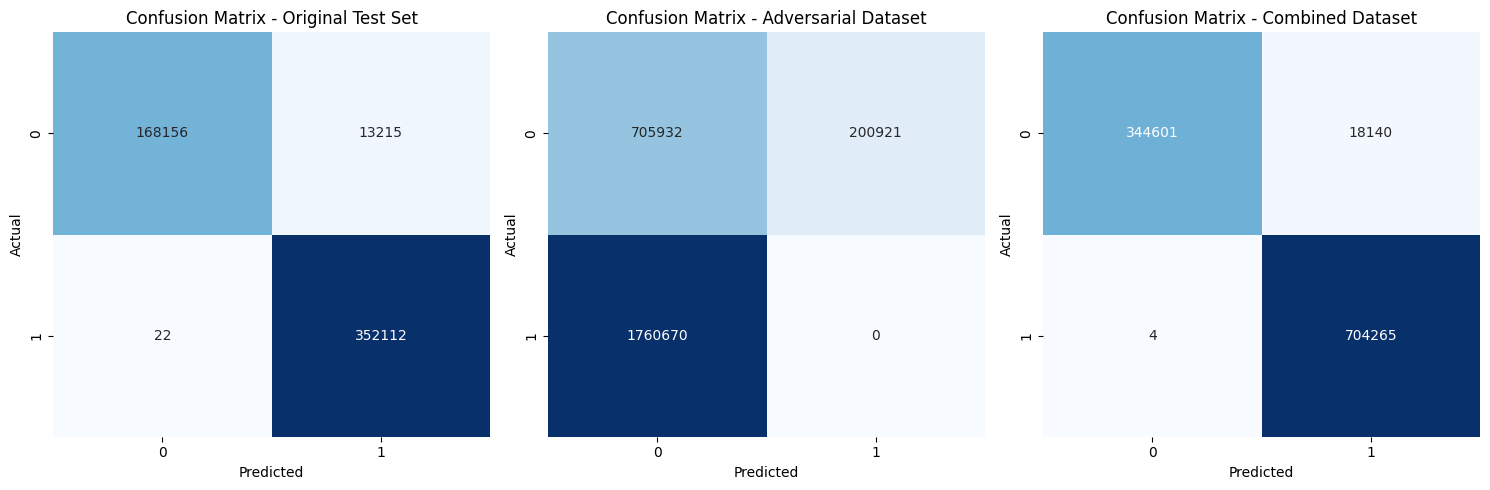

In [108]:
import seaborn as sns

# Figure 2: Confusion Matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Original Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(adv_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Adversarial Dataset')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Combined Dataset')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## ROC-AUC Curves

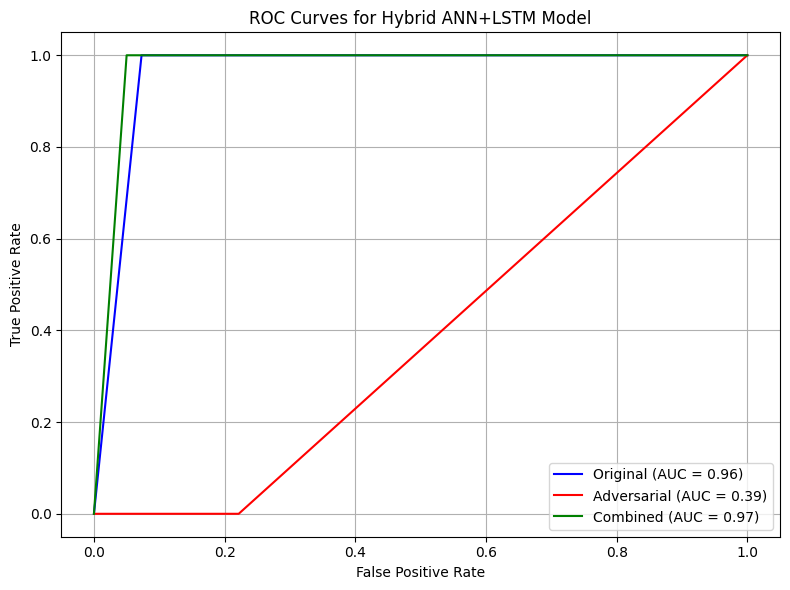

In [116]:
from sklearn.metrics import roc_auc_score


plt.figure(figsize=(8, 6))

# Original Test Set ROC
y_pred_prob_hybrid = model.predict(X_test_lstm, verbose=0)
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_test_pred)
auc_orig = roc_auc_score(y_test, y_test_pred)
plt.plot(fpr_orig, tpr_orig, label=f'Original (AUC = {auc_orig:.2f})', color='blue')

# Adversarial Dataset ROC
y_pred_prob_adv = model.predict(X_combined_adv_lstm, verbose=0)
fpr_adv, tpr_adv, _ = roc_curve(y_combined, y_adv_pred)
auc_adv = roc_auc_score(y_combined, y_adv_pred)
plt.plot(fpr_adv, tpr_adv, label=f'Adversarial (AUC = {auc_adv:.2f})', color='red')

# Combined Dataset ROC
y_pred_prob_combined = model.predict(X_test_final, verbose=0)
fpr_combined, tpr_combined, _ = roc_curve(y_test_final, y_pred_final)
auc_combined = roc_auc_score(y_test_final, y_pred_final)
plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC = {auc_combined:.2f})', color='green')

plt.title('ROC Curves for Hybrid ANN+LSTM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()